In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale

from sklearn.model_selection import train_test_split

import os

pd.set_option('display.max_columns', None)
# hide warnings
import warnings
warnings.filterwarnings('ignore')



In [2]:
def replace_low_freq(df, threshold=100, replacement='other'):
    s = df.stack()
    c = s.value_counts()
    m = pd.Series(replacement, c.index[c <= threshold])
    return s.replace(m).unstack()

In [3]:
def findSkewedColumns(columns, df, thresholdPercent = 80, displayValueCounts = False):
    skewedColumns = []
    for col in columns:
        valueCounts = (100*df[col].value_counts(normalize=True)).to_dict()
        if(displayValueCounts):
            print(col)
            print(valueCounts)
        abovethreshold = list(filter(lambda x:x>thresholdPercent, valueCounts.values()))
        if(len(abovethreshold)>0):
            skewedColumns.append(col)
    return skewedColumns

In [4]:
pricingInfo = pd.read_csv('train.csv')
pricingInfo.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,Gas

In [5]:
pricingInfo.shape

(1460, 81)

In [6]:
pricingInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Inspecting and handling null values

In [7]:
# inspect null values
nulls = round(100*(pricingInfo.isnull().sum()/len(pricingInfo.index)), 2).sort_values(ascending=False)
nulls = nulls[nulls.values>0]
nulls

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
FireplaceQu     47.26
LotFrontage     17.74
GarageCond       5.55
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
BsmtExposure     2.60
BsmtFinType2     2.60
BsmtFinType1     2.53
BsmtCond         2.53
BsmtQual         2.53
MasVnrArea       0.55
MasVnrType       0.55
Electrical       0.07
dtype: float64

In [8]:
pricingInfo.FireplaceQu.value_counts(normalize=True, dropna=False) 

NaN    0.472603
Gd     0.260274
TA     0.214384
Fa     0.022603
Ex     0.016438
Po     0.013699
Name: FireplaceQu, dtype: float64

In [9]:
# droping columns with >40% of null values and id column
pricingInfo.drop(['Id','PoolQC', 'Alley', 'Fence', 'MiscFeature', 'FireplaceQu'], axis=1, inplace=True)

In [10]:
nulls = round(100*(pricingInfo.isnull().sum()/len(pricingInfo.index)), 2).sort_values(ascending=False)
nulls = nulls[nulls.values>0]
nulls

LotFrontage     17.74
GarageType       5.55
GarageYrBlt      5.55
GarageCond       5.55
GarageQual       5.55
GarageFinish     5.55
BsmtExposure     2.60
BsmtFinType2     2.60
BsmtFinType1     2.53
BsmtCond         2.53
BsmtQual         2.53
MasVnrArea       0.55
MasVnrType       0.55
Electrical       0.07
dtype: float64

In [11]:
## impute null values 
columnsToImpute = nulls.index
columnsToImpute = columnsToImpute.drop('GarageYrBlt') #it's a numerical column
for col in columnsToImpute:
    isCategorical = pricingInfo.dtypes[col]=='object'
    if(isCategorical):
        #select mode to impute these columns
        valueToImpute = pricingInfo[col].mode()[0]
    else:
        #select mean to impute these columns
        valueToImpute = round(pricingInfo[col].mean(), 2)
    pricingInfo[col].fillna(valueToImpute, inplace=True)

In [12]:
pricingInfo.GarageYrBlt.describe()

count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

In [13]:
# garage can either be build during initial construction or during remodaling. We are making an assumption here. 
pricingInfo.loc[pricingInfo.GarageYrBlt.isnull(), 'GarageYrBlt'] = pricingInfo['YearRemodAdd']

In [14]:
#investigate nulls again
round(100*(pricingInfo.isnull().sum()/len(pricingInfo.index)), 2).sort_values(ascending=False)

SalePrice       0.0
YearRemodAdd    0.0
RoofMatl        0.0
Exterior1st     0.0
Exterior2nd     0.0
               ... 
KitchenAbvGr    0.0
KitchenQual     0.0
TotRmsAbvGrd    0.0
Functional      0.0
MSSubClass      0.0
Length: 75, dtype: float64

## Exploratory data analysis

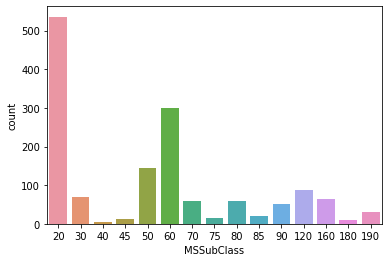

In [15]:
#Type of dwellings in sale
sns.countplot(pricingInfo.MSSubClass)

#### Observation. 
Most of the houses for sale are 1 storey wtih 1946 or above model or 2 story wtih 1946 or above model

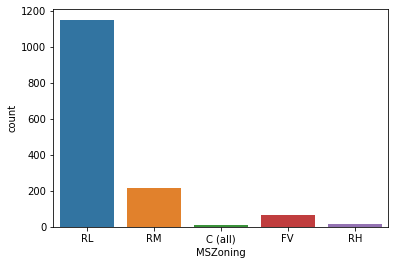

In [16]:
#Areas with number of properties for sale. 
sns.countplot(pricingInfo.MSZoning)

#### Observation
Most of the properties up for sale are in residentaiol areas with low density

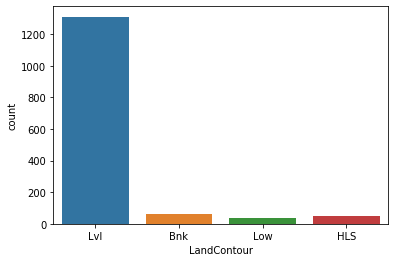

In [17]:
# number of properties for sale based on land conditions
sns.countplot(pricingInfo.LandContour)

In [18]:
pricingInfo.LandContour.value_counts(normalize=True)

Lvl    0.897945
Bnk    0.043151
HLS    0.034247
Low    0.024658
Name: LandContour, dtype: float64

#### Observation
Approx 90% of the values in given data are in level fields. This column is highly skewed.

In [19]:
pricingInfo.drop('LandContour', axis=1, inplace=True)

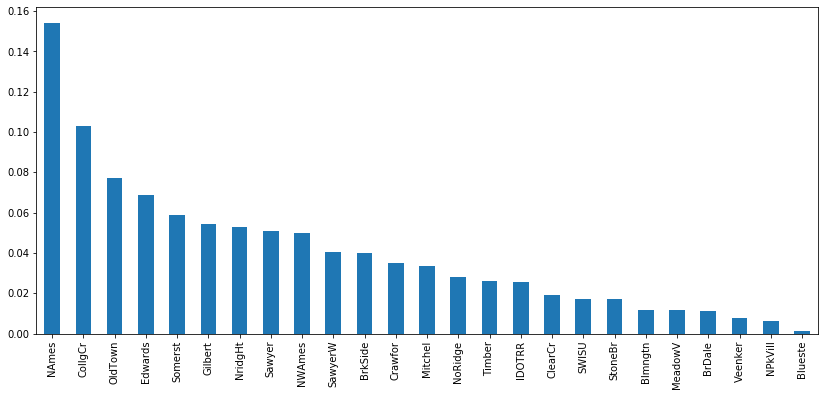

In [20]:
plt.figure(figsize=(14,6))
pricingInfo.Neighborhood.value_counts(normalize=True).plot.bar()

### Observation
North Ames has the highest number of properties up for sale followed by College creek

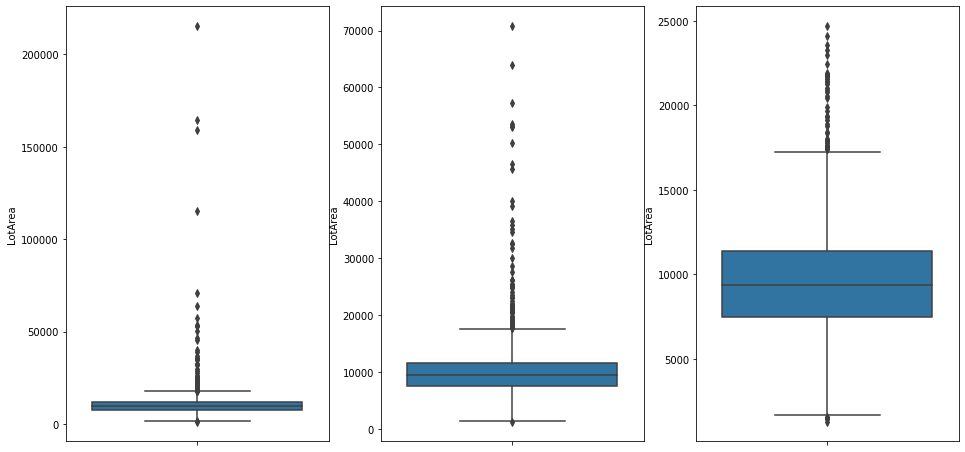

In [21]:
#Lot area distribution
plt.figure(figsize=(16,8))
plt.subplot(1, 3,1)
sns.boxplot(x='LotArea', data=pricingInfo, orient='v')

plt.subplot(1, 3,2)
sns.boxplot(x='LotArea', data=pricingInfo.loc[pricingInfo.LotArea<100000], orient='v')

plt.subplot(1, 3, 3)
sns.boxplot(x='LotArea', data=pricingInfo.loc[pricingInfo.LotArea<25000], orient='v')

In [22]:
pricingInfo.LotArea.describe(percentiles=[.1,.25,.3, .5,.75, .8,.9,.95,.97, .98 ,1])

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
10%        5000.000000
25%        7553.500000
30%        8063.700000
50%        9478.500000
75%       11601.500000
80%       12205.800000
90%       14381.700000
95%       17401.150000
97%       21571.800000
98%       25251.620000
100%     215245.000000
max      215245.000000
Name: LotArea, dtype: float64

#### Observation - 
95% of the properties have lot area less than 20000. We can consider this column for capping

In [23]:
pricingInfo.loc[pricingInfo.LotArea>25251,['LotArea']].sort_values(by='LotArea')[:1]

,LotArea
876,25286


In [24]:
pricingInfo.loc[pricingInfo.LotArea>25251,'LotArea'] = 25286  

### Dropping skewed columns

In [25]:
pricingInfo.SaleCondition.value_counts(normalize=True)

Normal     0.820548
Partial    0.085616
Abnorml    0.069178
Family     0.013699
Alloca     0.008219
AdjLand    0.002740
Name: SaleCondition, dtype: float64

In [26]:
pricingInfo.SaleType.value_counts(normalize=True)

WD       0.867808
New      0.083562
COD      0.029452
ConLD    0.006164
ConLw    0.003425
ConLI    0.003425
CWD      0.002740
Oth      0.002055
Con      0.001370
Name: SaleType, dtype: float64

In [27]:
pricingInfo.PavedDrive.value_counts(normalize=True)

Y    0.917808
N    0.061644
P    0.020548
Name: PavedDrive, dtype: float64

In [28]:
pricingInfo.shape

(1460, 74)

In [29]:
## logic to identify any skewed columns
columns = pricingInfo.select_dtypes('object').columns

In [30]:
skewedColumns = findSkewedColumns(columns, pricingInfo, 80, True)
print('Dropping these columns', skewedColumns)
pricingInfo.drop(skewedColumns, inplace =True, axis=1)

MSZoning
{'RL': 78.83561643835615, 'RM': 14.931506849315069, 'FV': 4.4520547945205475, 'RH': 1.095890410958904, 'C (all)': 0.684931506849315}
Street
{'Pave': 99.58904109589041, 'Grvl': 0.410958904109589}
LotShape
{'Reg': 63.35616438356164, 'IR1': 33.15068493150685, 'IR2': 2.808219178082192, 'IR3': 0.684931506849315}
Utilities
{'AllPub': 99.93150684931507, 'NoSeWa': 0.0684931506849315}
LotConfig
{'Inside': 72.05479452054794, 'Corner': 18.013698630136986, 'CulDSac': 6.438356164383562, 'FR2': 3.219178082191781, 'FR3': 0.273972602739726}
LandSlope
{'Gtl': 94.65753424657535, 'Mod': 4.4520547945205475, 'Sev': 0.8904109589041096}
Neighborhood
{'NAmes': 15.41095890410959, 'CollgCr': 10.273972602739725, 'OldTown': 7.739726027397261, 'Edwards': 6.8493150684931505, 'Somerst': 5.89041095890411, 'Gilbert': 5.410958904109589, 'NridgHt': 5.273972602739726, 'Sawyer': 5.068493150684931, 'NWAmes': 5.0, 'SawyerW': 4.041095890410959, 'BrkSide': 3.9726027397260277, 'Crawfor': 3.493150684931507, 'Mitchel': 

In [31]:
pricingInfo.shape


(1460, 55)

Text(0, 0.5, 'Percentage')

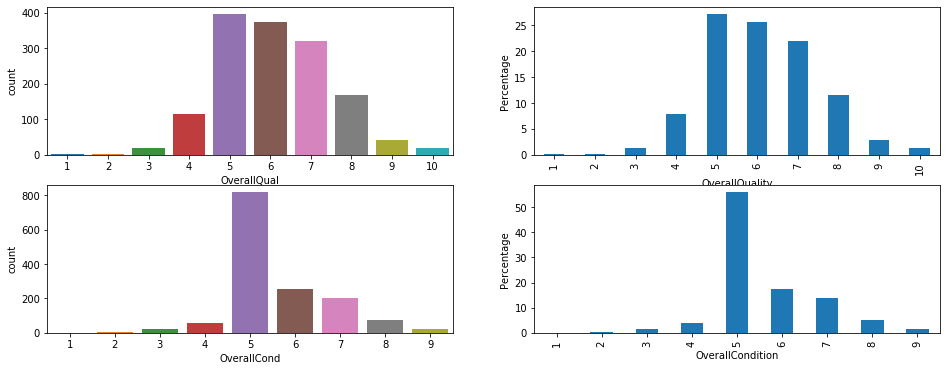

In [32]:
#Quality and condition of available properties
plt.figure(figsize=(16,6))
plt.subplot(2, 2,1)
sns.countplot(pricingInfo.OverallQual)

plt.subplot(2, 2,2)
(100*pricingInfo.OverallQual.value_counts(normalize=True, sort=False)).plot.bar()
plt.xlabel('OverallQuality')
plt.ylabel('Percentage')

plt.subplot(2, 2,3)
sns.countplot(pricingInfo.OverallCond)


plt.subplot(2, 2, 4)
(100*pricingInfo.OverallCond.value_counts(normalize=True, sort=False)).plot.bar()
plt.xlabel('OverallCondition')
plt.ylabel('Percentage')

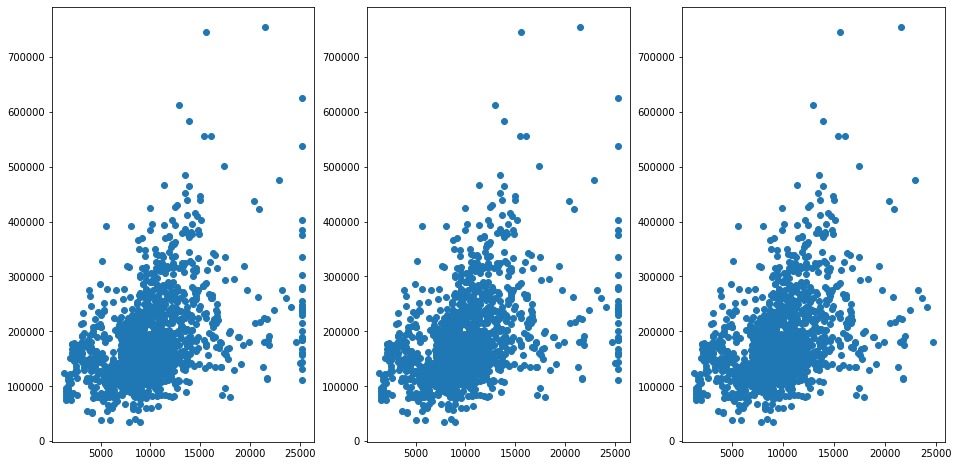

In [33]:
# area vs price
#Lot area distribution
plt.figure(figsize=(16,8))
plt.subplot(1, 3,1)
plt.scatter(x='LotArea', y='SalePrice', data=pricingInfo)

plt.subplot(1, 3,2)
plt.scatter(x='LotArea', y='SalePrice', data=pricingInfo.loc[pricingInfo.LotArea<40000])

plt.subplot(1, 3, 3)
plt.scatter(x='LotArea', y='SalePrice', data=pricingInfo.loc[pricingInfo.LotArea<25000])

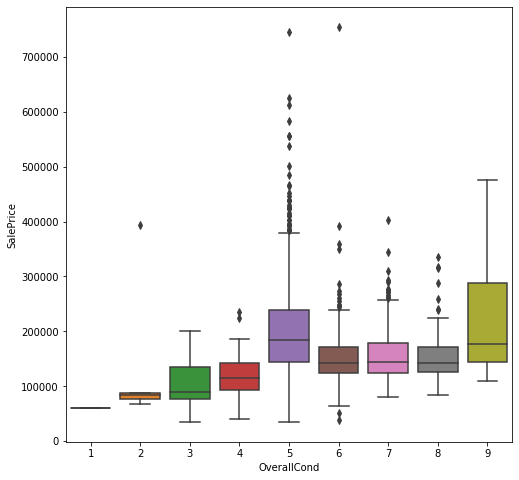

In [34]:
#OVerall condition vs pricing distribution
plt.figure(figsize=(8,8))
sns.boxplot(x='OverallCond',y='SalePrice',data=pricingInfo, orient='v')

#### Observation
median values of properties rated 5 and 9 are almost same. The properties rated 6, 7, 8 have lower median and high values. This column might not have much impact

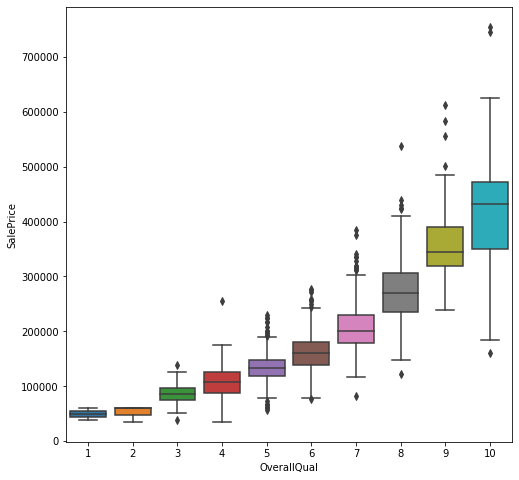

In [35]:
plt.figure(figsize=(8,8))
sns.boxplot(x='OverallQual',y='SalePrice',data=pricingInfo, orient='v')

#### Observation
We see the pricing of the properties keep increasing in a consistent manner as the overall quality of the property improves. Direct impact is evident

In [36]:
pricingInfo.YearBuilt.describe()

count    1460.000000
mean     1971.267808
std        30.202904
min      1872.000000
25%      1954.000000
50%      1973.000000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64

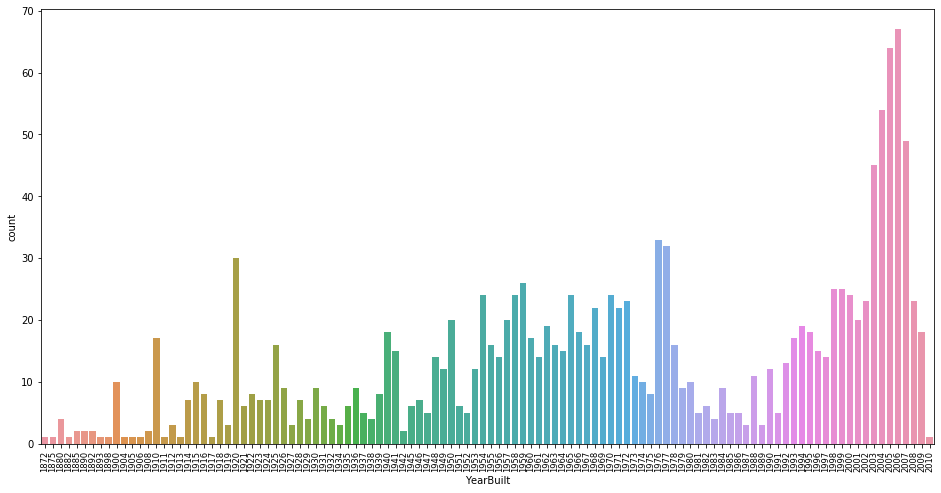

In [37]:
# number of properties by year
plt.figure(figsize=(16,8))
plt.xticks(rotation=90,fontweight='light',fontsize='small')
sns.countplot(pricingInfo.YearBuilt)

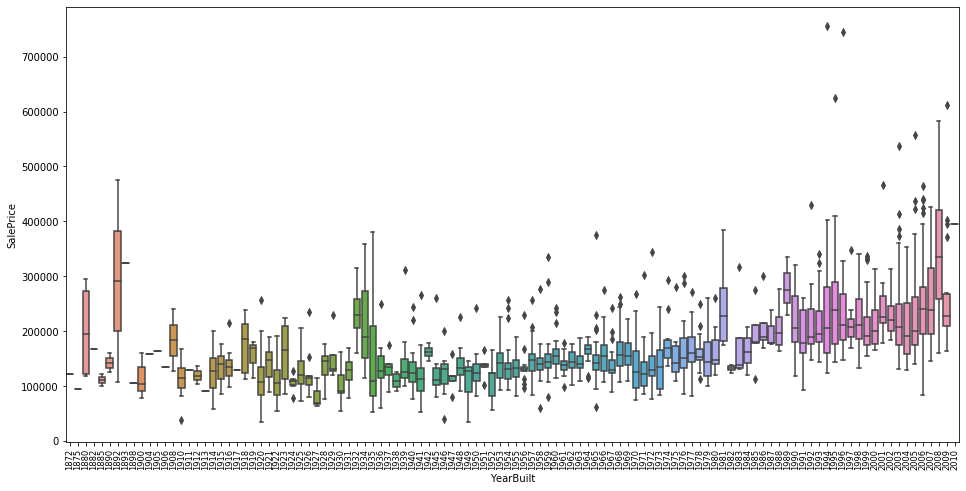

In [38]:
# number of properties by year
plt.figure(figsize=(16,8))
plt.xticks(rotation=90,fontweight='light',fontsize='small')
sns.boxplot(x='YearBuilt',y='SalePrice',data=pricingInfo, orient='v')

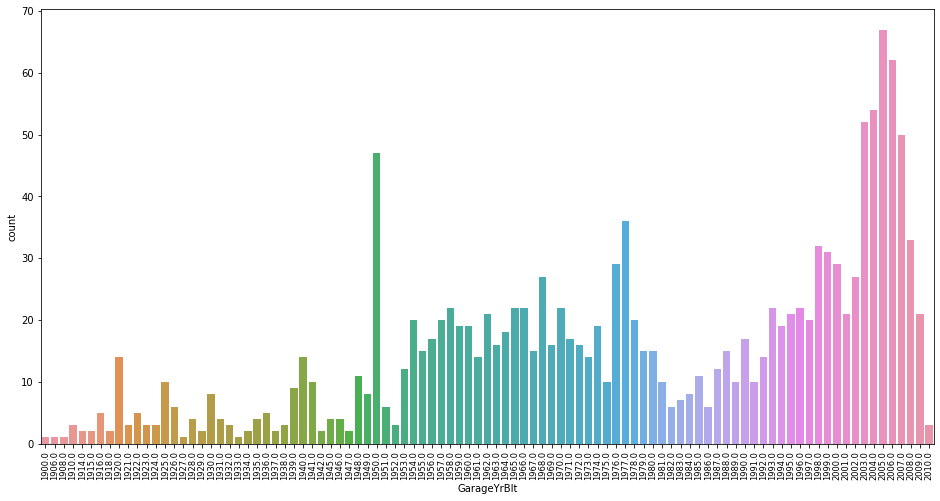

In [39]:
# number of properties by year
plt.figure(figsize=(16,8))
plt.xticks(rotation=90,fontweight='light',fontsize='small')
sns.countplot(pricingInfo.GarageYrBlt)

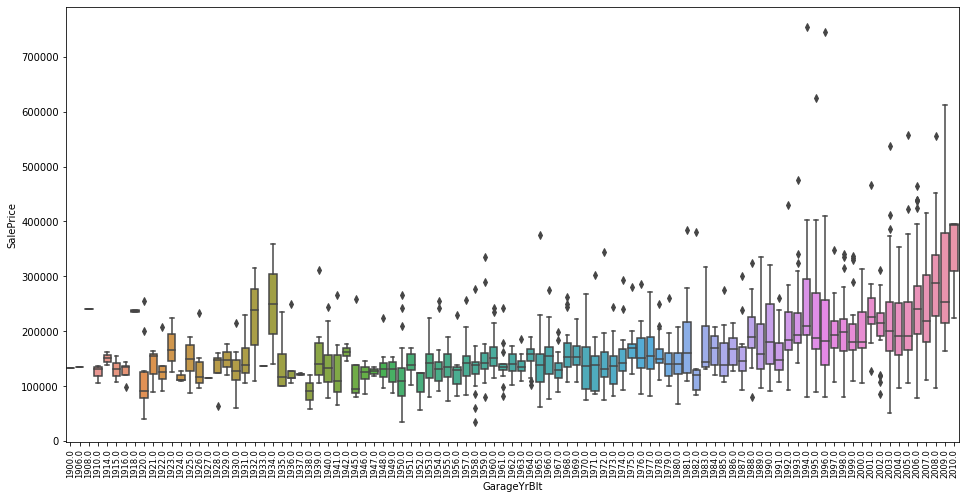

In [40]:
# number of properties by year
plt.figure(figsize=(16,8))
plt.xticks(rotation=90,fontweight='light',fontsize='small')
sns.boxplot(x='GarageYrBlt',y='SalePrice',data=pricingInfo, orient='v')

#### Observation
no direct relation between year of garage and price. hence dropping the column

In [41]:
pricingInfo.drop('GarageYrBlt', axis=1, inplace=True)

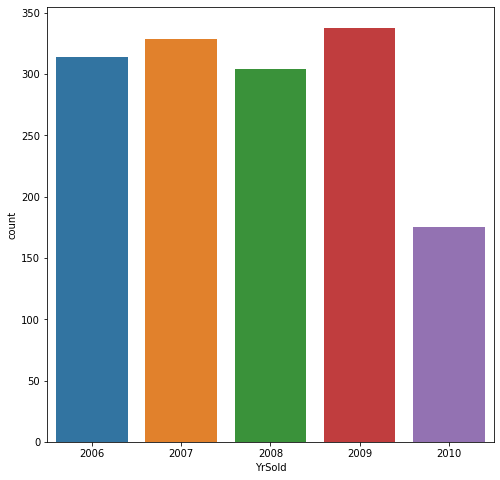

In [42]:
# properties sold by year
plt.figure(figsize=(8,8))
sns.countplot(x='YrSold', data=pricingInfo)

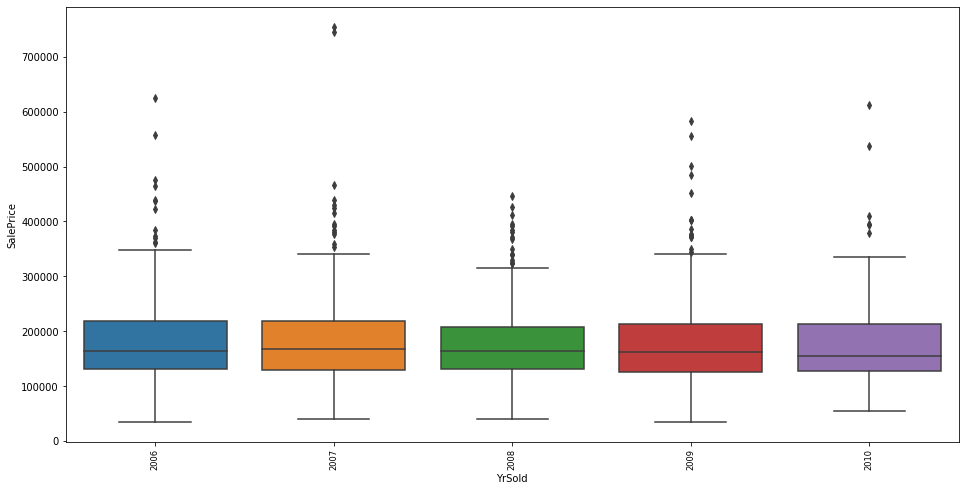

In [43]:
# year sold vs price
plt.figure(figsize=(16,8))
plt.xticks(rotation=90,fontweight='light',fontsize='small')
sns.boxplot(x='YrSold',y='SalePrice',data=pricingInfo, orient='v')

#### Observation
Market has been stable through years.
- Sales have been consitent
- Price ranges have also been in similar range with slight difference. 
- Since this is not impacting sales we may drop this column

In [44]:
pricingInfo.drop('YrSold', axis=1, inplace=True)

In [45]:
# inspect MasVnrArea
pricingInfo.MasVnrArea.describe(percentiles=[.1,.25,.3, .5,.75, .8,.9,.95,.97, .98,.99 ,1])

count    1460.000000
mean      103.685288
std       180.569112
min         0.000000
10%         0.000000
25%         0.000000
30%         0.000000
50%         0.000000
75%       164.250000
80%       205.200000
90%       335.000000
95%       456.000000
97%       573.690000
98%       650.820000
99%       791.280000
100%     1600.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

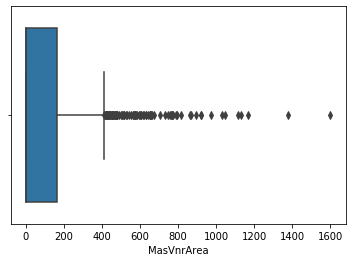

In [46]:
sns.boxplot(x='MasVnrArea', data=pricingInfo)

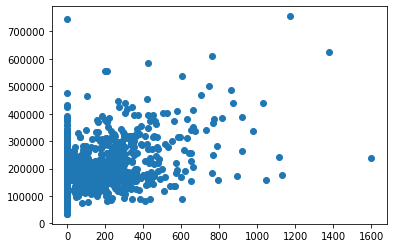

In [47]:
plt.scatter(x='MasVnrArea', y='SalePrice', data=pricingInfo)

#### Observation
Masonry veneer area does not seem to impact pricing. 

In [48]:
## caping this variable value so that outliers don't dicate result
pricingInfo.loc[pricingInfo.MasVnrArea>800,'MasVnrArea'] = 800

In [49]:
pricingInfo.MasVnrArea.describe(percentiles=[.1,.25,.3, .5,.75, .8,.9,.95,.97, .98,.99 ,1])

count    1460.000000
mean      101.268849
std       167.918167
min         0.000000
10%         0.000000
25%         0.000000
30%         0.000000
50%         0.000000
75%       164.250000
80%       205.200000
90%       335.000000
95%       456.000000
97%       573.690000
98%       650.820000
99%       791.280000
100%      800.000000
max       800.000000
Name: MasVnrArea, dtype: float64

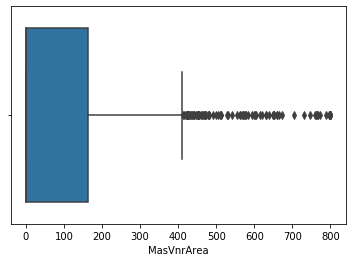

In [50]:
sns.boxplot(x='MasVnrArea', data=pricingInfo)

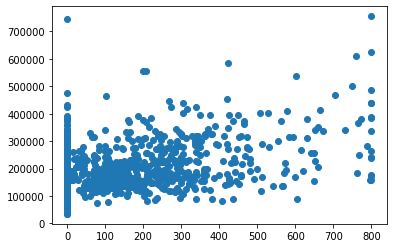

In [51]:
plt.scatter(x='MasVnrArea', y='SalePrice', data=pricingInfo)

In [52]:
# identify categorical variables from integer types
intColumns = pricingInfo.select_dtypes('int64').columns
print('possible categorical columns \n')
cat = []
for col in intColumns:
    if len(pricingInfo[col].value_counts().index)<10:
        print(col)
        print(pricingInfo[col].value_counts())
        print()
        cat.append(col)

possible categorical columns 

OverallCond
5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64

BsmtFullBath
0    856
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64

BsmtHalfBath
0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64

FullBath
2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64

HalfBath
0    913
1    535
2     12
Name: HalfBath, dtype: int64

BedroomAbvGr
3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

KitchenAbvGr
1    1392
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64

Fireplaces
0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

GarageCars
2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

PoolArea
0      1453
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64



#### Observation
Columns - PoolArea, KitchenAbvGr ,BsmtHalfBath are highly skewed and hence can be dropped

In [53]:
cat.remove('OverallCond') # we want to keep condition rating as numerical for average rating calculation etc
pricingInfo[cat] = pricingInfo[cat].astype('str')

In [54]:
pricingInfo[cat].dtypes

BsmtFullBath    object
BsmtHalfBath    object
FullBath        object
HalfBath        object
BedroomAbvGr    object
KitchenAbvGr    object
Fireplaces      object
GarageCars      object
PoolArea        object
dtype: object

In [55]:
#dropping skewed columns
skewedColumns = ['PoolArea', 'KitchenAbvGr', 'BsmtHalfBath']
pricingInfo.drop(skewedColumns, axis=1, inplace=True)
cat = [ele for ele in cat if ele not in skewedColumns] 
cat

['BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'Fireplaces',
 'GarageCars']

In [56]:
pricingInfo['BedroomAbvGr'] = replace_low_freq(pricingInfo[['BedroomAbvGr']],50 )['BedroomAbvGr']
pricingInfo['BedroomAbvGr'].value_counts(normalize=True)

3        0.550685
2        0.245205
4        0.145890
other    0.058219
Name: BedroomAbvGr, dtype: float64

In [57]:
# revisit the columns
for c in cat:
    print(c)
    print(pricingInfo[c].value_counts(normalize=False))
    print()

BsmtFullBath
0    856
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64

FullBath
2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64

HalfBath
0    913
1    535
2     12
Name: HalfBath, dtype: int64

BedroomAbvGr
3        804
2        358
4        213
other     85
Name: BedroomAbvGr, dtype: int64

Fireplaces
0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

GarageCars
2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64



In [58]:
print(intColumns)
print(cat)
print(skewedColumns)

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'SalePrice'],
      dtype='object')
['BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'Fireplaces', 'GarageCars']
['PoolArea', 'KitchenAbvGr', 'BsmtHalfBath']


In [59]:
### handling outliers

columnsForOutliers = [c for c in intColumns if c not in cat and c not in skewedColumns]
print(columnsForOutliers)



['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'MoSold', 'SalePrice']


In [60]:
# we have handled first 6 columns separately.
columnsForOutliers=columnsForOutliers[6:]

In [61]:
skewedColumns = findSkewedColumns(columnsForOutliers,pricingInfo)

In [62]:
#drop skewedColumns
pricingInfo.drop(skewedColumns, axis=1, inplace=True)

# columns now left for outlier treatment
columnsForOutliers = [c for c in columnsForOutliers if c not in skewedColumns]

BsmtFinSF1
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
GrLivArea
TotRmsAbvGrd
GarageArea
WoodDeckSF
OpenPorchSF
MoSold
SalePrice


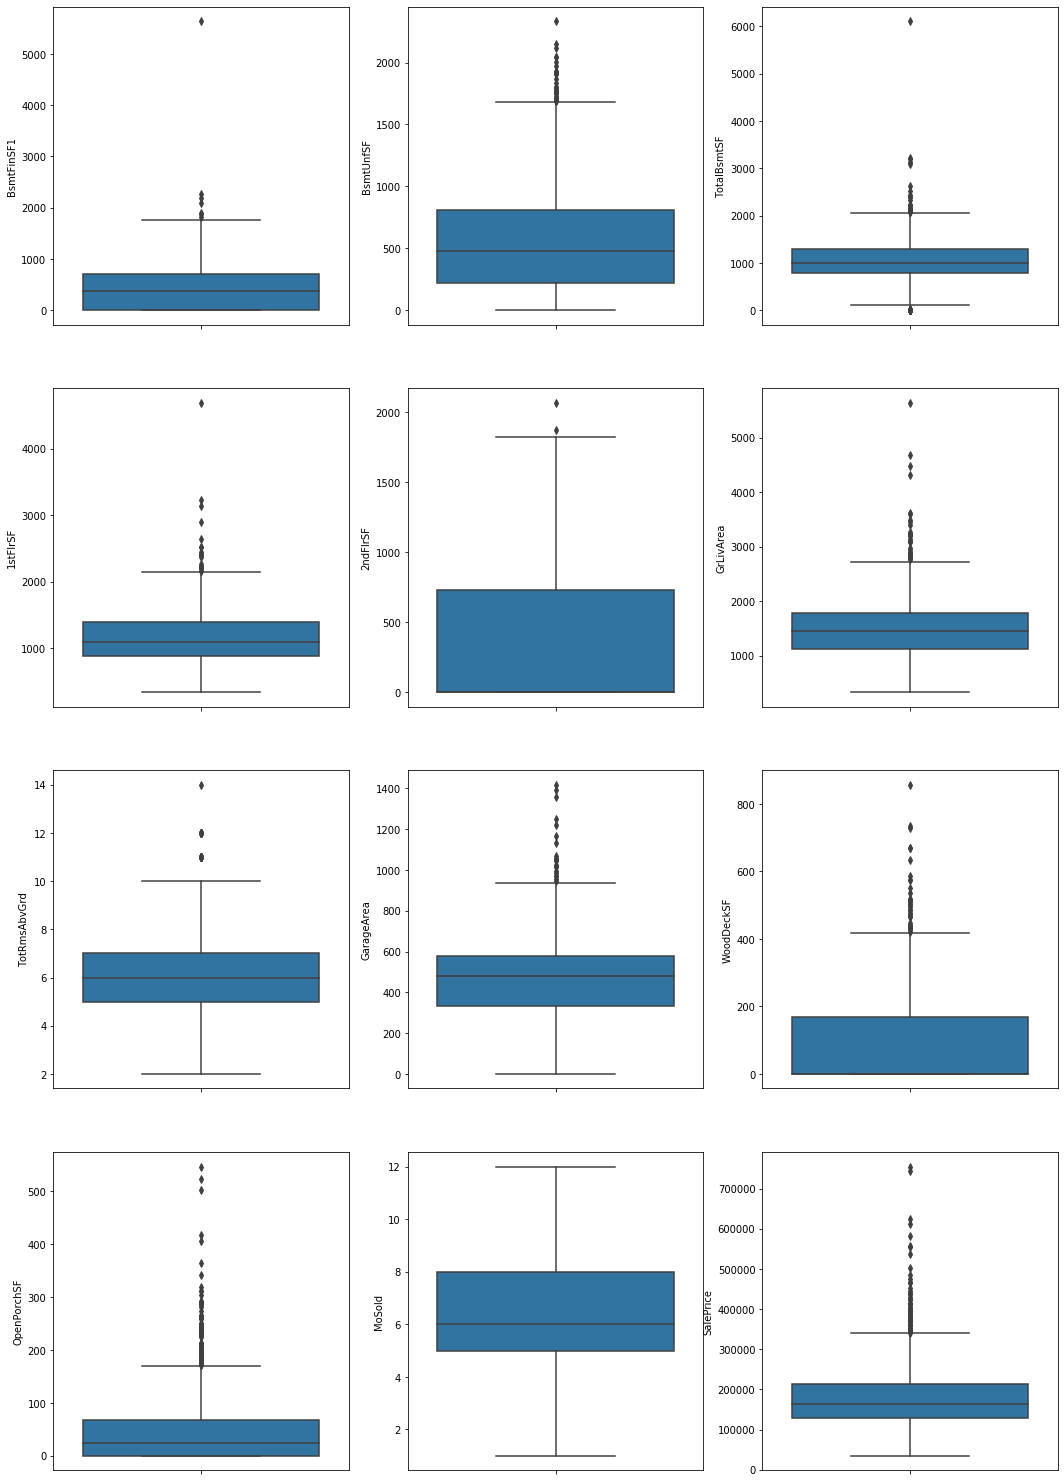

In [63]:
plt.figure(figsize=(18,48))
i=1
for col in columnsForOutliers:
    print(col)
    plt.subplot(7, 3, i)
    sns.boxplot(x=col, data=pricingInfo, orient='v')
    i=i+1

#### Observation 
Following columns need outlier treatment
- TotalBsmtSF
- 1stFlrSF
- GrLivArea
- WoodDeckSF
- OpenPorchSF

In [64]:
pricingInfo.TotalBsmtSF.describe(percentiles=[.1,.25,.3, .5,.75, .8,.9,.95,.97, .98 ,1])

count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
10%       636.900000
25%       795.750000
30%       840.000000
50%       991.500000
75%      1298.250000
80%      1391.200000
90%      1602.200000
95%      1753.000000
97%      1905.460000
98%      2001.640000
100%     6110.000000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

In [65]:
pricingInfo.shape

(1460, 44)

In [66]:
pricingInfo = pricingInfo.loc[pricingInfo.TotalBsmtSF<6000]
pricingInfo.shape

(1459, 44)

In [67]:
pricingInfo['1stFlrSF'].describe(percentiles=[.1,.25,.3, .5,.75, .8,.9,.95,.97, .98 ,1])

count    1459.000000
mean     1160.207676
std       375.503916
min       334.000000
10%       756.800000
25%       882.000000
30%       915.400000
50%      1086.000000
75%      1391.000000
80%      1482.000000
90%      1680.000000
95%      1828.300000
97%      1977.040000
98%      2069.000000
100%     3228.000000
max      3228.000000
Name: 1stFlrSF, dtype: float64

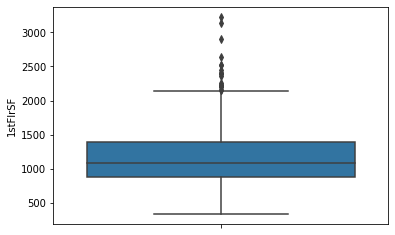

In [68]:
#1stFlrSF
sns.boxplot(x='1stFlrSF', data=pricingInfo, orient='v')

#### Observation
This column does not have outliers now

In [69]:
#GrLivArea
pricingInfo = pricingInfo.loc[pricingInfo.GrLivArea<4000]
pricingInfo.shape

(1456, 44)

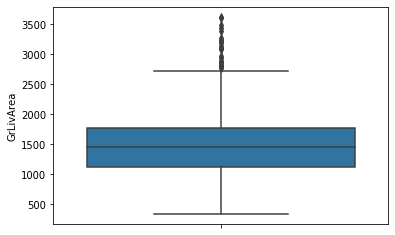

In [70]:
sns.boxplot(x='GrLivArea', data=pricingInfo, orient='v')

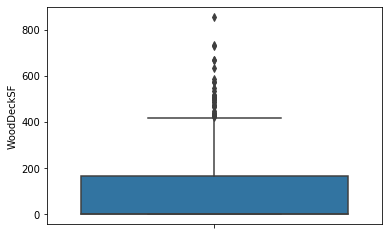

In [71]:
#WoodDeckSF
sns.boxplot(x='WoodDeckSF', data=pricingInfo, orient='v')

In [72]:
#GrLivArea
pricingInfo = pricingInfo.loc[pricingInfo.WoodDeckSF<600]
pricingInfo.shape

(1450, 44)

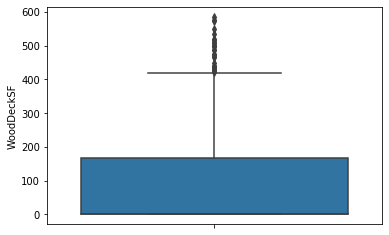

In [73]:
#WoodDeckSF
sns.boxplot(x='WoodDeckSF', data=pricingInfo, orient='v')

### Observation
No more outliers present

In [74]:
# % age of non zero values.
len(pricingInfo.loc[pricingInfo.WoodDeckSF>0].index)/len(pricingInfo.index)

0.47517241379310343

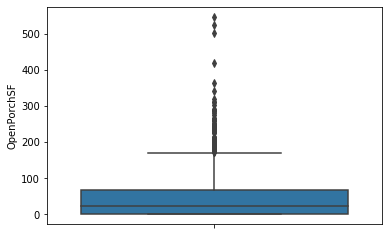

In [75]:
# OpenPorchSF
sns.boxplot(x='OpenPorchSF', data=pricingInfo, orient='v')

In [76]:
pricingInfo['OpenPorchSF'].describe(percentiles=[.1,.25,.3, .5,.75, .8,.9,.95,.97, .98 ,1])

count    1450.000000
mean       46.209655
std        65.447719
min         0.000000
10%         0.000000
25%         0.000000
30%         0.000000
50%        24.000000
75%        68.000000
80%        82.200000
90%       130.000000
95%       173.100000
97%       211.000000
98%       240.000000
100%      547.000000
max       547.000000
Name: OpenPorchSF, dtype: float64

In [77]:
pricingInfo.shape

(1450, 44)

In [78]:
#OpenPorchSF
pricingInfo = pricingInfo.loc[pricingInfo.OpenPorchSF<250]
pricingInfo.shape

(1426, 44)

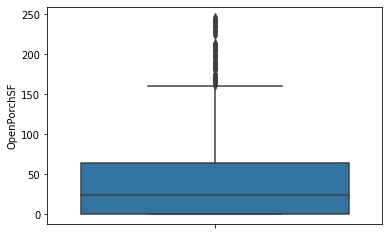

In [79]:
# OpenPorchSF
sns.boxplot(x='OpenPorchSF', data=pricingInfo, orient='v')

In [80]:
pricingInfo.shape

(1426, 44)

### Create dummy variables

In [81]:
catColumns = pricingInfo.select_dtypes('object')
catColumns

,MSZoning,LotShape,LotConfig,Neighborhood,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,Fireplaces,GarageType,GarageFinish,GarageCars
0,RL,Reg,Inside,CollgCr,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,No,GLQ,Ex,1,2,1,3,Gd,0,Attchd,RFn,2
1,RL,Reg,FR2,Veenker,1Story,Gable,MetalSd,MetalSd,None,TA,CBlock,Gd,Gd,ALQ,Ex,0,2,0,3,TA,1,Attchd,RFn,2
2,RL,IR1,Inside,CollgCr,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,Mn,GLQ,Ex,1,2,1,3,Gd,1,Attchd,RFn,2
3,RL,IR1,Corner,Crawfor,2Story,Gable,Wd Sdng,Wd Shng,None,TA,BrkTil,TA,No,ALQ,Gd,1,1,0,3,Gd,1,Detchd,Unf,3
4,RL,IR1,FR2,NoRidge,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,Av,GLQ,Ex,1,2,1,4,Gd,1,Attchd,RFn,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,FV,Reg,Inside,Somerst,1Story,Gable,VinylSd,VinylSd,None,Gd,PConc,Gd,No,GLQ,Ex,1,2,0,2,Gd,0,Attchd,RFn,2
1455,RL,Reg,Inside,Gilbert,2Story,Gable,VinylSd,VinylSd,None,TA,PConc,Gd,No,Unf,Ex,0,2,1,3,TA,1,Attchd,RFn,2
1456,RL,Reg,Inside,NWAmes,1Story,Gable,Plywood,Plywood,Stone,TA,CBlock,Gd,No,ALQ,TA,1,2,0,3,TA,2,Attchd,Unf,2
1457,RL,Reg,Inside,Crawfor,2Story,Gable,CemntBd,CmentBd,None,Ex,Stone,TA,No,GLQ,Ex,0,2,0,4,Gd,2,Attchd,RFn,1


In [82]:
dummyDf = pd.get_dummies(catColumns, drop_first=True, prefix= catColumns.columns)
dummyDf

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,BsmtFullBath_1,BsmtFullBath_2,BsmtFullBath_3,FullBath_1,FullBath_2,FullBath_3,HalfBath_1,HalfBath_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_other,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Fireplaces_1,Fireplaces_2,Fireplaces_3,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4
0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0
4,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [83]:
pricingInfo2 = pd.concat([pricingInfo, dummyDf], join='inner', axis=1)
pricingInfo2

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageType,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,BsmtFullBath_1,BsmtFullBath_2,BsmtFullBath_3,FullBath_1,FullBath_2,FullBath_3,HalfBath_1,HalfBath_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_other,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Fireplaces_1,Fireplaces_2,Fireplaces_3,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4
0,60,RL,65.0,8450,Reg,Inside,CollgCr,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,150,856,Ex,856,854,1710,1,2,1,3,Gd,8,0,Attchd,RFn,2,548,0,61,2,208500,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
1,20,RL,80.0,9600,Reg,FR2,Veenker,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,284,1262,Ex,1262,0,1262,0,2,0,3,TA,6,1,Attchd,RFn,2,460,298,0,5,181500,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0
2,60,RL,68.0,11250,IR1,Inside,CollgCr,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,434,920,Ex,920,866,1786,1,2,1,3,Gd,6,1,Attchd,RFn,2,608,0,42,9,223500,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,

In [84]:
#drop original variable
pricingInfo2.drop(catColumns, axis=1, inplace=True)

In [85]:
scaledColumns = pricingInfo2.select_dtypes(include=['int64', 'float64'])
cols = scaledColumns.columns
scaledColumns = pd.DataFrame(scale(scaledColumns))
scaledColumns.columns = cols
scaledColumns

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,SalePrice
0,0.075556,-0.226842,-0.319577,0.677365,-0.517470,1.052264,0.877679,0.577154,0.642397,-0.945929,-0.461567,-0.805379,1.201756,0.433097,0.954905,0.371344,-0.774491,0.359045,-1.603651,0.386985
1,-0.871639,0.491399,-0.041684,-0.058856,2.185505,0.153006,-0.426543,-0.605699,1.280792,-0.643226,0.523587,0.296063,-0.794495,-0.483589,-0.304175,-0.046747,1.745731,-0.768135,-0.490127,0.030047
2,0.075556,-0.083194,0.357032,0.677365,-0.517470,0.985653,0.829374,0.371965,0.126047,-0.304379,-0.306271,-0.631753,1.229807,0.588607,-0.304175,0.656407,-0.774491,0.007956,0.994571,0.585284
3,0.312355,-0.466255,-0.053766,0.677365,-0.517470,-1.878652,-0.716370,-0.605699,-0.507654,-0.064927,-0.704215,-0.520524,0.972678,0.447421,0.325365,0.817942,-0.774491,-0.121392,-1.603651,-0.518580
4,0.075556,0.682930,1.084387,1.413587,-0.517470,0.952347,0.732765,1.506538,0.522698,-0.177876,0.239688,-0.021348,1.666925,1.431631,1.584446,1.739644,0.849276,0.784047,2.108095,0.935613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1421,-0.871639,-0.370490,-0.549140,0.677365,-0.517470,1.085570,0.974288,-0.605699,-0.052328,0.547256,0.424101,0.184834,-0.794495,-0.567482,-0.304175,-0.331810,-0.774491,1.319920,1.365745,0.076317
1422,0.075556,-0.370490,-0.448374,-0.058856,-0.517470,0.919041,0.732765,-0.605699,-1.014615,0.868030,-0.226197,-0.542227,0.827752,0.304188,0.325365,-0.046747,-0.774491,-0.029000,0.623396,-0.055883
1423,-0.871639,0.730812,0.822201,-0.058856,0.383522,0.219618,0.153111,0.112461,0.839548,0.045763,1.203002,2.496236,-0.794495,1.175859,0.325365,0.143294,2.177044,-0.768135,-1.603651,0.406815
1424,0.312355,-0.178959,-0.176522,0.677365,3.086497,-1.012699,1.022592,-0.605699,-0.369179,0.696348,0.256673,0.095308,1.898341,1.722188,1.584446,-1.034964,-0.774491,0.340567,-0.490127,1.153741


In [86]:
#drop unscaled columns
pricingInfo2.drop(scaledColumns.columns, axis=1, inplace=True)

#concat dataframes to include scaled columns
pricingInfo2 = pd.concat([scaledColumns, pricingInfo2], join='inner', axis=1)
pricingInfo2

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,BsmtFullBath_1,BsmtFullBath_2,BsmtFullBath_3,FullBath_1,FullBath_2,FullBath_3,HalfBath_1,HalfBath_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_other,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Fireplaces_1,Fireplaces_2,Fireplaces_3,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4
0,0.075556,-0.226842,-0.319577,0.677365,-0.517470,1.052264,0.877679,0.577154,0.642397,-0.945929,-0.461567,-0.805379,1.201756,0.433097,0.954905,0.371344,-0.774491,0.359045,-1.603651,0.386985,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
1,-0.871639,0.491399,-0.041684,-0.058856,2.185505,0.153006,-0.426543,-0.605699,1.280792,-0.643226,0.523587,0.296063,-0.794495,-0.483589,-0.304175,-0.046747,1.745731,-0.768135,-0.490127,0.030047,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0
2,0.075556,-0.083194,0.357032,0.677365,-0.517470,0.985653,0.829374,0.371965,0.126047,-0.304379,-0.306271,-0.631753,1.229807,0.588607,-0.304175,0.656407,-0.774491,0.007956,0.994571,0.585284,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
3,0.312355,-0.466255,-0.053766,0.677365,-0.517470,-1.878652,-0.716370,-0.605699,-0.507654,-0.064927,-0.704215,-0.520524,0.972678,0.447421,0.325365,0.817942,-0.774491,-0.121392,-1.603651,-0.518580,0,0,1,0,

In [87]:
y= pricingInfo2['SalesPrice']
X = pricingInfo2.drop('SalesPrice', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7,test_size = 0.3, random_state=100)

KeyError: 'SalesPrice'